# **Prediksi Harga Saham BBRI Menggunakan RNN & LSTM**

---

Nilai-nilai berikut ini merupakan nilai hyperparameter dari model yang ditentukan pengguna sebelum melakukan prediksi. Pada bagian ini merupakan load model yang sudah dilakukan pencarian nilai terbaik dengan cara melakukan `Hyperparameter RandomizedSearchCV.`

# Install Libraries

In [3]:
%pip install numpy pandas scikeras tensorflow matplotlib scikit-learn==1.5.0

Note: you may need to restart the kernel to use updated packages.


# Import Libraries/Ambil Modul

In [ ]:
import os  # Interaksi sistem operasi
import numpy as np  # Komputasi numerik
import tensorflow as tf # Deep learning
import pandas as pd # Manipulasi dan analisis data
import math  # Fungsi matematika standar
import sys  # Informasi sistem
import sklearn # Library scikit-learn
import logging  # Modul untuk logging
import matplotlib.pyplot as plt # Visualisasi data
from sklearn.preprocessing import MinMaxScaler # Penskalaan data
from sklearn.metrics import mean_squared_error, root_mean_squared_error, mean_absolute_error # Metrik Evaluasi

print(f"TensorFlow version: {tf.__version__}")
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")
print(f"Scikit-learn version: {sklearn.__version__}")
print(f"Python version: {sys.version}")

folder_path = "plots"
if not os.path.exists(folder_path):
    os.makedirs(folder_path)

TensorFlow version: 2.18.0
NumPy version: 2.0.2
Pandas version: 2.2.3
Scikit-learn version: 1.5.0
Python version: 3.12.7 (tags/v3.12.7:0b05ead, Oct  1 2024, 03:06:41) [MSC v.1941 64 bit (AMD64)]


# Preprocessing Data

### Data & Visualization



In [2]:
# Menampilkan data saham BBRI
df = pd.read_excel('datasets/BBRI_2010-2025.xlsx')
df

,Date,Open,High,Low,Close,Volume
0,2010-01-04,408.44,411.06,400.59,408.44,125094160
1,2010-01-05,411.06,413.68,408.44,411.06,163644326
2,2010-01-06,405.82,416.29,403.20,405.82,104842810
3,2010-01-07,400.59,405.82,395.35,400.59,101933260
4,2010-01-08,403.20,403.20,395.35,403.20,87237006
...,...,...,...,...,...,...
3696,2024-12-20,3723.15,3768.88,3704.85,3714.00,252689600
3697,2024-12-23,3778.03,3851.21,3759.74,3851.21,167689800
3698,2024-12-24,3860.36,3887.81,3814.62,3842.07,199536100
3699,2024-12-27,3875.15,3894.05,3856.24,3875.15,143104400


In [3]:
# Memilih kolom date sebagai index
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Memilih kolom close untuk prediksi
df= df[['Close']]

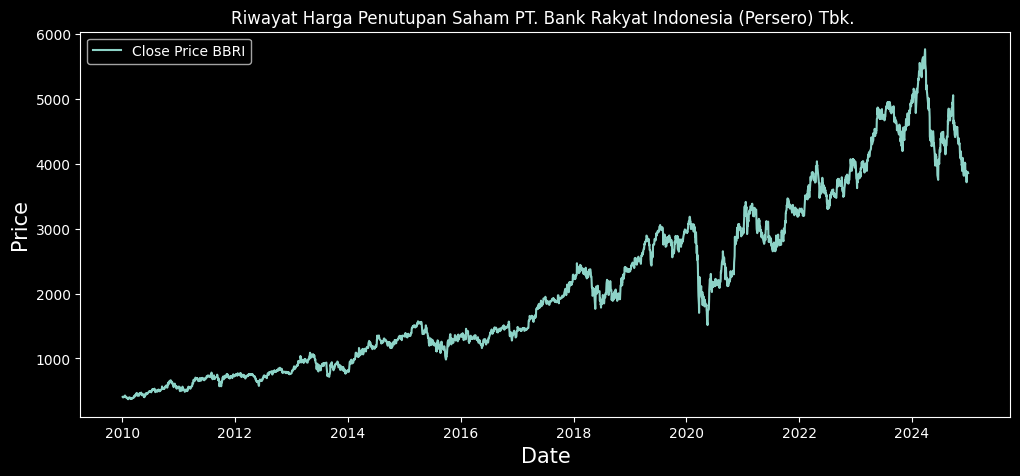

In [4]:
# Visualisasi data harga penutupan
plt.style.use('dark_background')
plt.figure(figsize=(12, 5))
plt.title('Riwayat Harga Penutupan Saham PT. Bank Rakyat Indonesia (Persero) Tbk. ')
plt.plot(df['Close'], label='Close Price BBRI')
plt.xlabel('Date', fontsize=15)
plt.ylabel('Price', fontsize=15)
plt.legend()
plt.show()

### Splitting Data Training, Validasi dan Testing

Dataset dibagi menjadi set pelatihan `70%`, set validasi `15%`, dan set pengujian`15%`.

In [5]:
# Konversi data ke numpy array, Reshape data ke 2D array
data = df.filter(['Close']).values.reshape(-1, 1)
data, data.shape

(array([[ 408.44],
        [ 411.06],
        [ 405.82],
        ...,
        [3842.07],
        [3875.15],
        [3856.24]]),
 (3701, 1))

In [6]:
# Rasio pembagian data :
length_data = len(data) # Panjang data

# Tentukan jumlah data untuk masing-masing set
train_len = math.ceil(length_data * 0.7)  # 70% data untuk training
val_len = int(length_data * 0.15)   # 15% data untuk validation
test_len = length_data - (train_len + val_len)  # Sisa 15% untuk testing

print("Total Data :", length_data)
print("Training Data  :", train_len)
print("Validation Data :", val_len)
print("Testing Data :", test_len)

Total Data : 3701
Training Data  : 2591
Validation Data : 555
Testing Data : 555


### Normalization Data

Pada langkah ini, saya memisahkan data training, validasi dan testing. Pertama, saya memproses data latih terlebih dahulu. `MinMaxScaler` digunakan untuk menormalisasikan data, menskalakannya ke kisaran antara `0` dan `1`.

In [7]:
train_data = df.iloc[:train_len]
val_data = df.iloc[train_len: train_len + val_len]
test_data = df.iloc[train_len + val_len:]
train_data[:5], val_data[:5], test_data[-5:]

(             Close
 Date              
 2010-01-04  408.44
 2010-01-05  411.06
 2010-01-06  405.82
 2010-01-07  400.59
 2010-01-08  403.20,
               Close
 Date               
 2020-06-03  2162.51
 2020-06-04  2134.61
 2020-06-05  2169.49
 2020-06-08  2302.03
 2020-06-09  2239.24,
               Close
 Date               
 2024-12-20  3714.00
 2024-12-23  3851.21
 2024-12-24  3842.07
 2024-12-27  3875.15
 2024-12-30  3856.24)

In [8]:
# Normalisasi data training dengan MinMaxScaler
sc = MinMaxScaler(feature_range=(0, 1))
train_set = data[0:train_len]
train_scaled_data = sc.fit_transform(train_set)
train_scaled_data

array([[0.01304339],
       [0.01397556],
       [0.01211121],
       ...,
       [0.54529606],
       [0.59989967],
       [0.65698671]])

### Sliding Window Technique

In [9]:
# Membuat fungsi untuk pembentukan teknik sliding window
x_train = []
y_train = []

time_step = 30

for i in range(time_step, len(train_scaled_data)):
    x_train.append(train_scaled_data[i-time_step:i, 0])
    y_train.append(train_scaled_data[i, 0])

    if i<= time_step:
      print(x_train)
      print(y_train)
      print()

[array([0.01304339, 0.01397556, 0.01211121, 0.01025041, 0.01117903,
       0.01117903, 0.01397556, 0.01397556, 0.01397556, 0.01304339,
       0.01490774, 0.02049726, 0.0186329 , 0.01490774, 0.01490774,
       0.01304339, 0.00931823, 0.00838605, 0.01025041, 0.01025041,
       0.00838605, 0.00838605, 0.00838605, 0.00558951, 0.00279654,
       0.        , 0.00279654, 0.00093218, 0.00372871, 0.00838605])]
[np.float64(0.009318228718218774)]



In [10]:
# Mengubah tipe data list menjadi numpy array 2D
x_train, y_train = np.array(x_train), np.array(y_train)

print("x_train before reshape :",x_train.shape)
print("y_train before reshape :",y_train.shape)

x_train before reshape : (2561, 30)
y_train before reshape : (2561,)


In [11]:
# Ubah bentuk data menjadi bentuk yang diterima oleh model ke dalam bentuk 3D (Sample, Time_Step, Feature)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1)) 
y_train = np.reshape(y_train, (y_train.shape[0],1))

print("x_train after reshape :",x_train.shape)
print("y_train after reshape :",y_train.shape)

x_train after reshape : (2561, 30, 1)
y_train after reshape : (2561, 1)


In [12]:
# pembentukan data validasi dan scalling data
val_set = data[train_len - time_step :(train_len + val_len), :]
val_scaled_data = sc.transform(val_set)

# Buat fungsi pembentukan teknik sliding window seperti sebelumnya
x_val = []
y_val = []

for i in range(time_step, len(val_scaled_data)):
    x_val.append(val_scaled_data[i - time_step:i, 0])
    y_val.append(val_scaled_data[i, 0])

x_val, y_val = np.array(x_val), np.array(y_val)
x_val = np.reshape(x_val, (x_val.shape[0], x_val.shape[1], 1))
y_val = np.reshape(y_val, (y_val.shape[0],1))

In [13]:
# Pembentukan data testing dan scalling data
test_set = data[(-test_len - time_step):, :]
test_scaled_data = sc.transform(test_set)

# Pementukan data untuk melakukan prediksi pada data testing
x_test = []
y_test = df[['Close']].iloc[-test_len :, :].values
for i in range(time_step, len(test_scaled_data )):
    x_test.append(test_scaled_data [i-time_step:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# RNN Model

### Load Best Model RNN

In [14]:
# Memuat model terbaik yang telah disimpan sebelumnya (termasuk bobot dan arsitektur)
logging.info("Memuat model terbaik yang telah disimpan...")
best_model_RNN = tf.keras.models.load_model("model_checkpoints/best_RNN_model.keras")
best_model_RNN.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 30, 128)        │        16,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 148,997 (582.02 KB)

 Trainable params: 49,665 (194.00 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 99,332 (388.02 KB)

### Load Training Result RNN

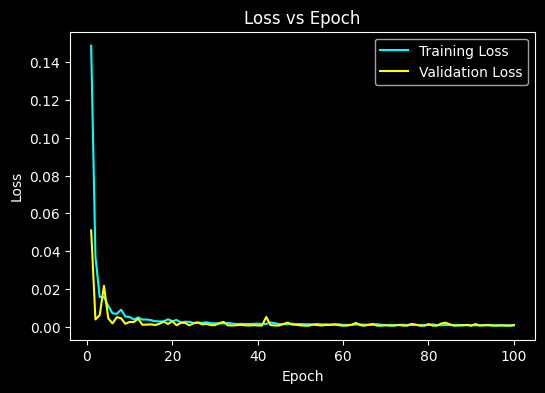

In [15]:
# Load CSV
df_loss_RNN = pd.read_csv("training_results/RNN_loss_history.csv")

# Plot loss
plt.style.use('dark_background')
plt.figure(figsize=(6,4))
plt.plot(df_loss_RNN["epoch"], df_loss_RNN["training_loss"], label="Training Loss", color="cyan") # Changed df to df_loss
plt.plot(df_loss_RNN["epoch"], df_loss_RNN["validation_loss"], label="Validation Loss", color="yellow") # Changed df to df_loss
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss vs Epoch")
plt.legend()

# Simpan plot ke dalam folder dengan resolusi tinggi
file_path = os.path.join(folder_path, 'RNN_Training and loss validation ')
plt.savefig(file_path, dpi=300, bbox_inches='tight')
plt.show()

## RNN Prediction

In [16]:
# Proses prediksi
y_pred_RNN = best_model_RNN.predict(x_test)
y_pred_RNN = sc.inverse_transform(y_pred_RNN)

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step


In [17]:
# Prediksi data tesing
df_pred_RNN = df[-test_len:].copy()
df_pred_RNN['Prediction'] = np.round(y_pred_RNN, 2)

# Atur tampilan float agar hanya 2 angka di belakang koma
pd.set_option('display.float_format', '{:.2f}'.format)
df_pred_RNN

,Close,Prediction
Date,,
2022-09-13,3741.92,3716.05
2022-09-14,3741.92,3735.75
2022-09-15,3766.43,3731.23
2022-09-16,3676.56,3743.94
2022-09-19,3733.75,3676.16
...,...,...
2024-12-20,3714.00,3727.98
2024-12-23,3851.21,3706.31
2024-12-24,3842.07,3805.00


In [18]:
# Evaluasi dengan metrik
mse = mean_squared_error(y_test, y_pred_RNN)
rmse = root_mean_squared_error(y_test, y_pred_RNN)
mae = mean_absolute_error(y_test, y_pred_RNN)

# Evaluasi model yang dimuat
print(f'Testing Data Performance Metrics :')
print(f'=====================================')
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'Mean Absolute Error (MAE): {mae}\n')

training_loss = best_model_RNN.evaluate(x_train, y_train, verbose=2)
validation_loss = best_model_RNN.evaluate(x_val, y_val, verbose=2)
# Normalisasi ulang testing loss
testing_loss = mean_squared_error(sc.transform(y_test), sc.transform(y_pred_RNN))

print(f"\nTraining Loss: {training_loss}")
print(f"Validation Loss: {validation_loss}")
print(f"Testing Loss (In Normalized): {testing_loss}")

Testing Data Performance Metrics :
Mean Squared Error (MSE): 9340.063365167684
Root Mean Squared Error (RMSE): 96.64400325507881
Mean Absolute Error (MAE): 76.57329497466216

81/81 - 1s - 9ms/step - loss: 1.4500e-04
18/18 - 0s - 7ms/step - loss: 4.5832e-04

Training Loss: 0.00014500062388833612
Validation Loss: 0.0004583218542393297
Testing Loss (In Normalized): 0.0011823500778433106


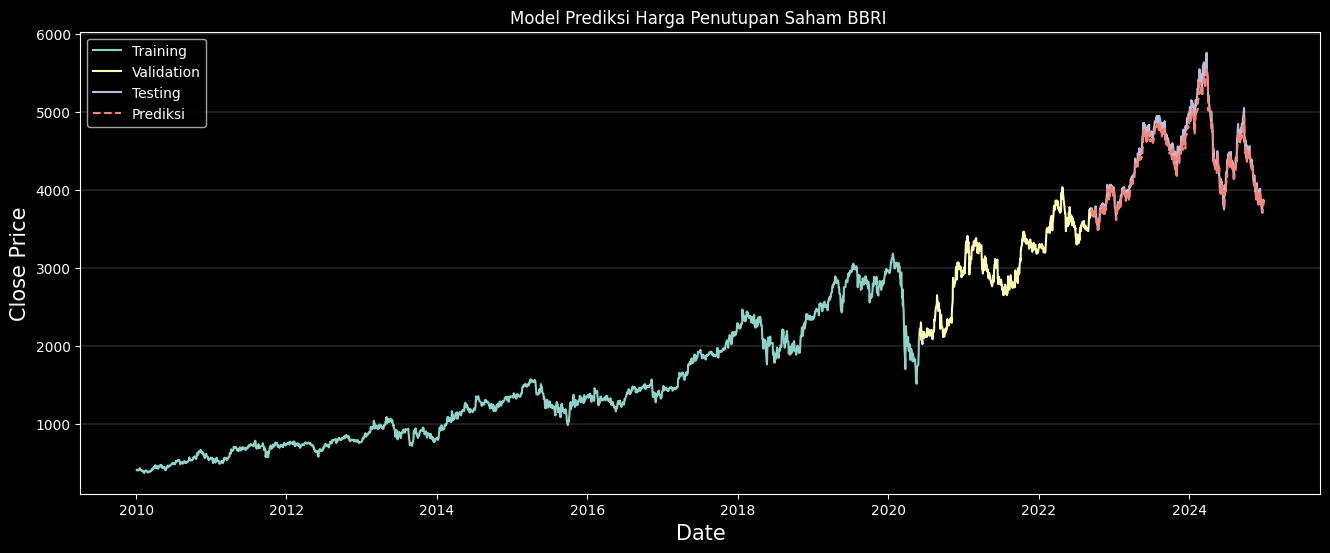

In [19]:
# Membuat data untuk visualisasi
train = df[:train_len]
valid = df[train_len:(train_len + val_len)]

# visualisasi prediksi
plt.figure(figsize=(16, 6))
plt.title('Model Prediksi Harga Penutupan Saham BBRI ')
plt.plot(train.index, train['Close'], label='Training') # Use train.index for x-axis
plt.plot(valid.index, valid['Close'], label='Validation') # Use valid.index for x-axis
plt.plot(df_pred_RNN.index, df_pred_RNN['Close'], label='Testing') # Use df_pred.index for x-axis
plt.plot(df_pred_RNN.index, df_pred_RNN['Prediction'], label='Prediksi', linestyle='--') # Use df_pred.index for x-axis
plt.xlabel('Date', fontsize=15)
plt.ylabel('Close Price', fontsize=15)
plt.legend()
plt.grid(True, linewidth=0.18, axis='y')
plt.show()

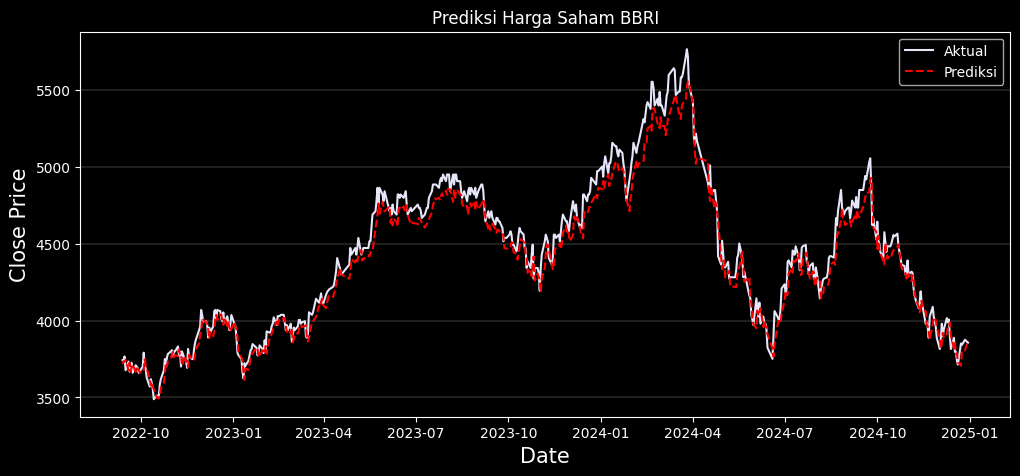

In [20]:
# Fokus kepada data testing
plt.figure(figsize=(12, 5))
plt.title('Prediksi Harga Saham BBRI')
plt.xlabel('Date', fontsize=15)
plt.ylabel('Close Price', fontsize=15)
plt.plot(df_pred_RNN.index, df_pred_RNN['Close'], label='Aktual', color ='lavender')
plt.plot(df_pred_RNN.index, df_pred_RNN['Prediction'], label='Prediksi', color='red', linestyle='--')
plt.legend()
plt.grid(True, linewidth=0.18, axis='y')
plt.show()

# LSTM Model

### Load Best Model LSTM

In [21]:
# Memuat model terbaik yang telah disimpan sebelumnya (termasuk bobot dan arsitektur)
logging.info("Memuat model terbaik yang telah disimpan...")

# Load model tanpa compile untuk menghindari error 'mse'
best_model_LSTM = tf.keras.models.load_model(
    "model_checkpoints/best_LSTM_model.keras", 
    compile=False
)

# Compile ulang model dengan fungsi loss eksplisit
best_model_LSTM.compile(
    optimizer='adam', 
    loss=tf.keras.losses.MeanSquaredError()
)

# Tampilkan arsitektur model
best_model_LSTM.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 256)            │       264,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 264,449 (1.01 MB)

 Trainable params: 264,449 (1.01 MB)

 Non-trainable params: 0 (0.00 B)

### Load Training Result LSTM

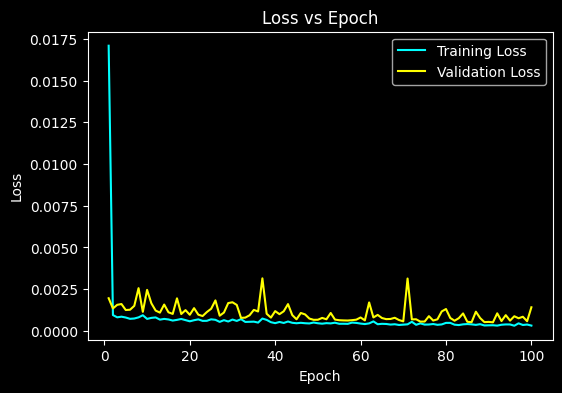

In [22]:
# Load CSV
df_loss_LSTM = pd.read_csv("training_results/LSTM_loss_history.csv")

# Plot loss
plt.style.use('dark_background')
plt.figure(figsize=(6,4))
plt.plot(df_loss_LSTM ["epoch"], df_loss_LSTM ["training_loss"], label="Training Loss", color="cyan")
plt.plot(df_loss_LSTM ["epoch"], df_loss_LSTM ["validation_loss"], label="Validation Loss", color="yellow")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss vs Epoch")
plt.legend()
# Simpan plot ke dalam folder dengan resolusi tinggi
file_path = os.path.join(folder_path, 'LSTM_Training and loss validation ')
plt.savefig(file_path, dpi=300, bbox_inches='tight')
plt.show()

## LSTM Prediction

In [23]:
# Proses prediksi
y_pred_LSTM = best_model_LSTM.predict(x_test)
y_pred_LSTM = sc.inverse_transform(y_pred_LSTM)

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step


In [ ]:
# Prediksi data tesing
df_pred_LSTM = df[-test_len:].copy()
df_pred_LSTM['Prediction'] = np.round(y_pred_LSTM, 2)
# Atur tampilan float agar hanya 2 angka di belakang koma

pd.set_option('display.float_format', '{:.2f}'.format)
df_pred_LSTM

,Close,Prediction
Date,,
2022-09-13,3741.92,3748.41
2022-09-14,3741.92,3744.14
2022-09-15,3766.43,3742.94
2022-09-16,3676.56,3756.96
2022-09-19,3733.75,3719.16
...,...,...
2024-12-20,3714.00,3767.10
2024-12-23,3851.21,3730.03
2024-12-24,3842.07,3788.01


In [25]:
# Evaluasi dengan metrik
mse = mean_squared_error(y_test, y_pred_LSTM)
rmse = root_mean_squared_error(y_test, y_pred_LSTM)
mae = mean_absolute_error(y_test, y_pred_LSTM)

# Evaluasi model yang dimuat
print(f'Testing Data Performance Metrics :')
print(f'=====================================')
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'Mean Absolute Error (MAE): {mae}\n')

training_loss = best_model_LSTM.evaluate(x_train, y_train, verbose=2)
validation_loss = best_model_LSTM.evaluate(x_val, y_val, verbose=2)
# Normalisasi ulang testing loss
testing_loss = mean_squared_error(sc.transform(y_test), sc.transform(y_pred_LSTM))

print(f"\nTraining Loss: {training_loss}")
print(f"Validation Loss: {validation_loss}")
print(f"Testing Loss (In Normalized): {testing_loss}")

Testing Data Performance Metrics :
Mean Squared Error (MSE): 5535.33403424788
Root Mean Squared Error (RMSE): 74.39982549877304
Mean Absolute Error (MAE): 57.25745625703831

81/81 - 1s - 18ms/step - loss: 1.8600e-04
18/18 - 0s - 25ms/step - loss: 5.1771e-04

Training Loss: 0.0001860015036072582
Validation Loss: 0.0005177106359042227
Testing Loss (In Normalized): 0.0007007123925979965


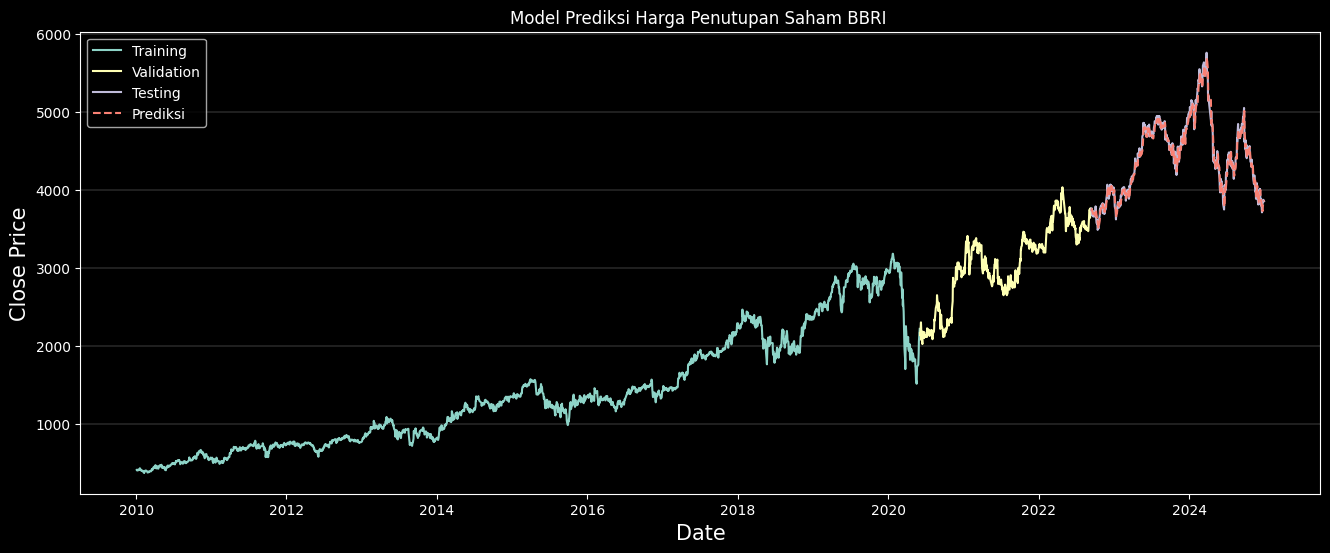

In [26]:
# Membuat data untuk visualisasi
train = df[:train_len]
valid = df[train_len:(train_len + val_len)]

# visualisasi prediksi
plt.figure(figsize=(16, 6))
plt.title('Model Prediksi Harga Penutupan Saham BBRI ')
plt.plot(train.index, train['Close'], label='Training') # Use train.index for x-axis
plt.plot(valid.index, valid['Close'], label='Validation') # Use valid.index for x-axis
plt.plot(df_pred_LSTM.index, df_pred_LSTM['Close'], label='Testing') # Use df_pred.index for x-axis
plt.plot(df_pred_LSTM.index, df_pred_LSTM['Prediction'], label='Prediksi', linestyle='--') # Use df_pred.index for x-axis
plt.xlabel('Date', fontsize=15)
plt.ylabel('Close Price', fontsize=15)
plt.legend()
plt.grid(True, linewidth=0.18, axis='y')
plt.show()

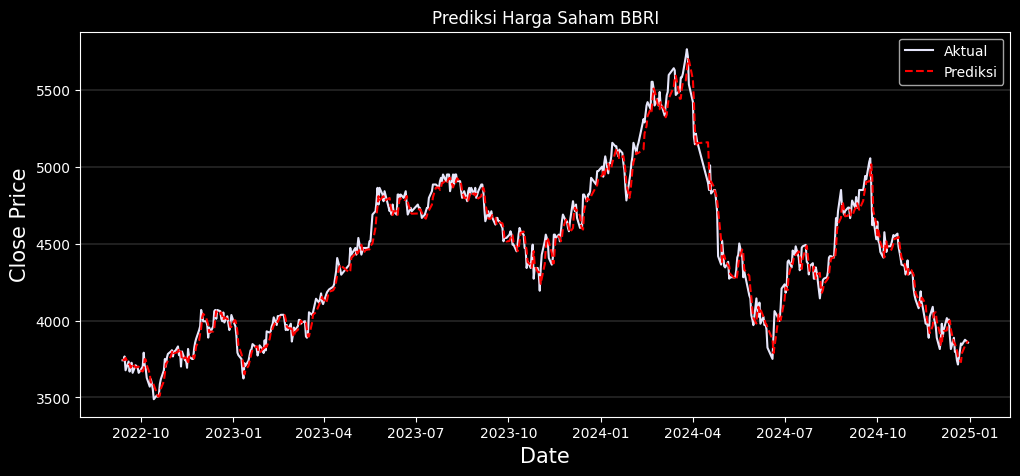

In [27]:
# Fokus kepada data testing
plt.figure(figsize=(12, 5))
plt.title('Prediksi Harga Saham BBRI')
plt.xlabel('Date', fontsize=15)
plt.ylabel('Close Price', fontsize=15)
plt.plot(df_pred_LSTM.index, df_pred_LSTM['Close'], label='Aktual', color ='lavender')
plt.plot(df_pred_LSTM.index, df_pred_LSTM['Prediction'], label='Prediksi', color='red', linestyle='--')
plt.legend()
plt.grid(True, linewidth=0.18, axis='y')
plt.show()

# RNN vs LSTM Prediction

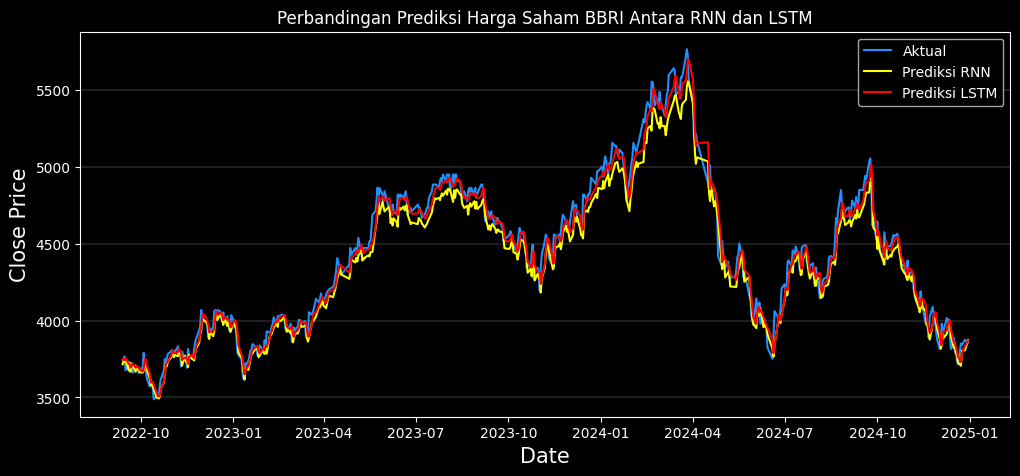

In [28]:
# Fokus kepada data testing anatara RNN dan LSTM
plt.figure(figsize=(12, 5))
plt.title('Perbandingan Prediksi Harga Saham BBRI Antara RNN dan LSTM')
plt.xlabel('Date', fontsize=15)
plt.ylabel('Close Price', fontsize=15)
plt.plot(df_pred_RNN.index, df_pred_RNN['Close'], label='Aktual', color='#1E90ff')
plt.plot(df_pred_RNN.index, df_pred_RNN['Prediction'], label='Prediksi RNN', color='yellow')
plt.plot(df_pred_LSTM.index, df_pred_LSTM['Prediction'], label='Prediksi LSTM', color='red')
plt.legend()
plt.grid(True, linewidth=0.18, axis='y')

# Simpan plot ke dalam folder dengan resolusi tinggi
file_path = os.path.join(folder_path, 'RNN_vs_LSTM.png')
plt.savefig(file_path, dpi=300, bbox_inches='tight')
plt.show()

# RNN vs LSTM Prediction T+1 dan T+30

In [29]:
# Ambil 30 hari terakhir harga penutupan dan skala data menjadi nilai antara 0 dan 1
last_30_days = df['Close'][- time_step:].values.reshape(-1, 1)  # Menggunakan kolom 'Close'
last_30_days_scaled = sc.transform(last_30_days)

# Buat list kosong
x_test = []
x_test.append(last_30_days_scaled)

# Ubah dataset x_test menjadi array numpy
x_test = np.array(x_test)

# Ubah bentuk data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# Dapatkan prediksi harga yang telah diskalakan
pred_price_RNN = best_model_RNN.predict(x_test)
pred_price_LSTM = best_model_LSTM.predict(x_test)

# Kembalikan skala data
pred_price_RNN  = sc.inverse_transform(pred_price_RNN )
pred_price_LSTM = sc.inverse_transform(pred_price_LSTM)
print(f'Prediksi Harga Penutupan Hari Berikutnya (RNN): {pred_price_RNN[0][0]:.2f}')
print(f'Prediksi Harga Penutupan Hari Berikutnya (LSTM): {pred_price_LSTM[0][0]:.2f}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Prediksi Harga Penutupan Hari Berikutnya (RNN): 3838.24
Prediksi Harga Penutupan Hari Berikutnya (LSTM): 3866.99


In [57]:
# === Ambil 30 hari terakhir (time_step) dan skala data ===
last_30_days = df['Close'][-time_step:].values.reshape(-1, 1)
last_30_days_scaled = sc.transform(last_30_days)

# === Siapkan input terpisah untuk RNN dan LSTM ===
temp_input_rnn = list(last_30_days_scaled)
temp_input_lstm = list(last_30_days_scaled)

# === Tempat menyimpan hasil prediksi ===
predicted_price_RNN_scaled = []
predicted_price_LSTM_scaled = []

# === Prediksi 14 hari ke depan ===
for _ in range(14):
    # RNN
    x_rnn = np.array(temp_input_rnn[-time_step:]).reshape(1, time_step, 1)
    pred_rnn = best_model_RNN.predict(x_rnn, verbose=0)
    predicted_price_RNN_scaled.append(pred_rnn[0][0])
    temp_input_rnn.append(pred_rnn[0].tolist())

    # LSTM
    x_lstm = np.array(temp_input_lstm[-time_step:]).reshape(1, time_step, 1)
    pred_lstm = best_model_LSTM.predict(x_lstm, verbose=0)
    predicted_price_LSTM_scaled.append(pred_lstm[0][0])
    temp_input_lstm.append(pred_lstm[0].tolist())

# === Kembalikan ke skala harga asli ===
predicted_price_RNN = sc.inverse_transform(np.array(predicted_price_RNN_scaled).reshape(-1, 1))
predicted_price_LSTM = sc.inverse_transform(np.array(predicted_price_LSTM_scaled).reshape(-1, 1))


# Tampilkan hasil
for i in range(14):
    print(f"Hari ke-{i+1:2d} | RNN: {predicted_price_RNN[i][0]:.2f} | LSTM: {predicted_price_LSTM[i][0]:.2f}")


Hari ke- 1 | RNN: 3838.24 | LSTM: 3866.99
Hari ke- 2 | RNN: 3811.70 | LSTM: 3863.08
Hari ke- 3 | RNN: 3812.77 | LSTM: 3860.44
Hari ke- 4 | RNN: 3806.18 | LSTM: 3859.14
Hari ke- 5 | RNN: 3791.67 | LSTM: 3858.67
Hari ke- 6 | RNN: 3770.19 | LSTM: 3858.61
Hari ke- 7 | RNN: 3743.83 | LSTM: 3858.67
Hari ke- 8 | RNN: 3732.44 | LSTM: 3858.74
Hari ke- 9 | RNN: 3727.00 | LSTM: 3858.78
Hari ke-10 | RNN: 3715.24 | LSTM: 3858.77
Hari ke-11 | RNN: 3699.58 | LSTM: 3858.73
Hari ke-12 | RNN: 3682.34 | LSTM: 3858.65
Hari ke-13 | RNN: 3675.09 | LSTM: 3858.55
Hari ke-14 | RNN: 3674.77 | LSTM: 3858.43


In [1]:
import yfinance as yf
from datetime import datetime, timedelta

# Tanggal mulai
start_date = datetime(2025, 1, 1)

# Ambil data sampai 60 hari ke depan (biar cukup untuk 30 hari bursa)
end_date = start_date + timedelta(days=60)

# Format ke string
start_str = start_date.strftime('%Y-%m-%d')
end_str = end_date.strftime('%Y-%m-%d')

# Ambil data
ticker = 'BBRI.JK'
bbri_data = yf.download(ticker, start=start_str, end=end_str)

# Ambil hanya kolom Close
bbri_close = bbri_data[['Close']]

# Ambil hanya 30 hari perdagangan pertama
bbri_close_30 = bbri_close.head(14)

# Tampilkan
print(bbri_close_30)

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed

Price             Close
Ticker          BBRI.JK
Date                   
2025-01-02  3979.114746
2025-01-03  3922.405273
2025-01-06  3875.147217
2025-01-07  3808.986328
2025-01-08  3856.244141
2025-01-09  3808.986328
2025-01-10  3790.083008
2025-01-13  3638.857910
2025-01-14  3591.599854
2025-01-15  3865.695801
2025-01-16  3931.856689
2025-01-17  3865.695801
2025-01-20  3988.566162
2025-01-21  4026.372559


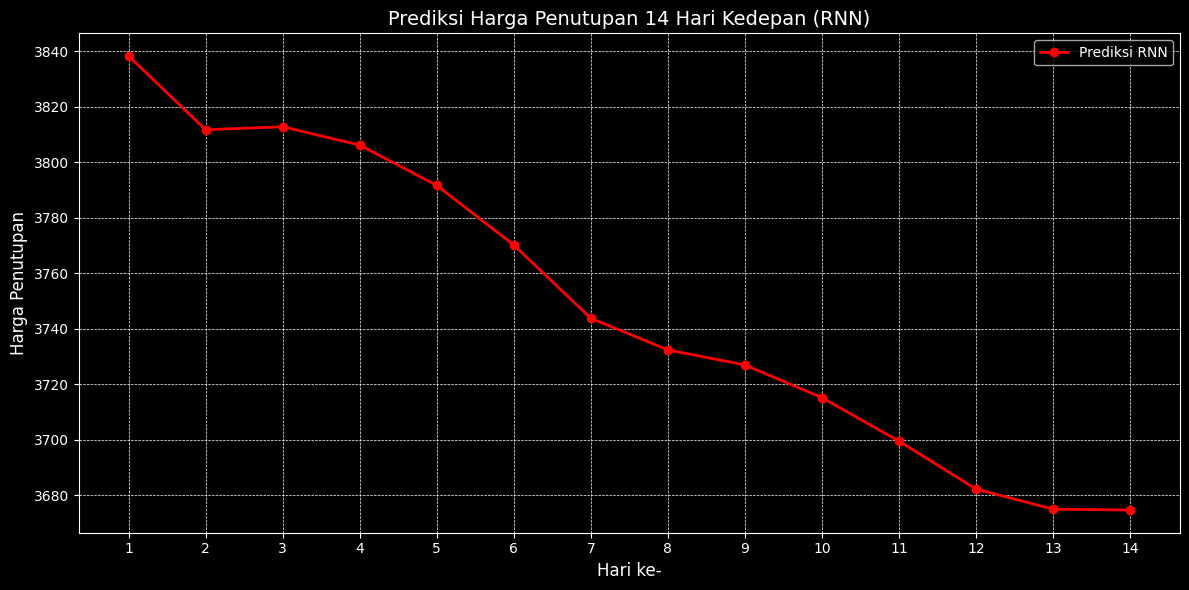

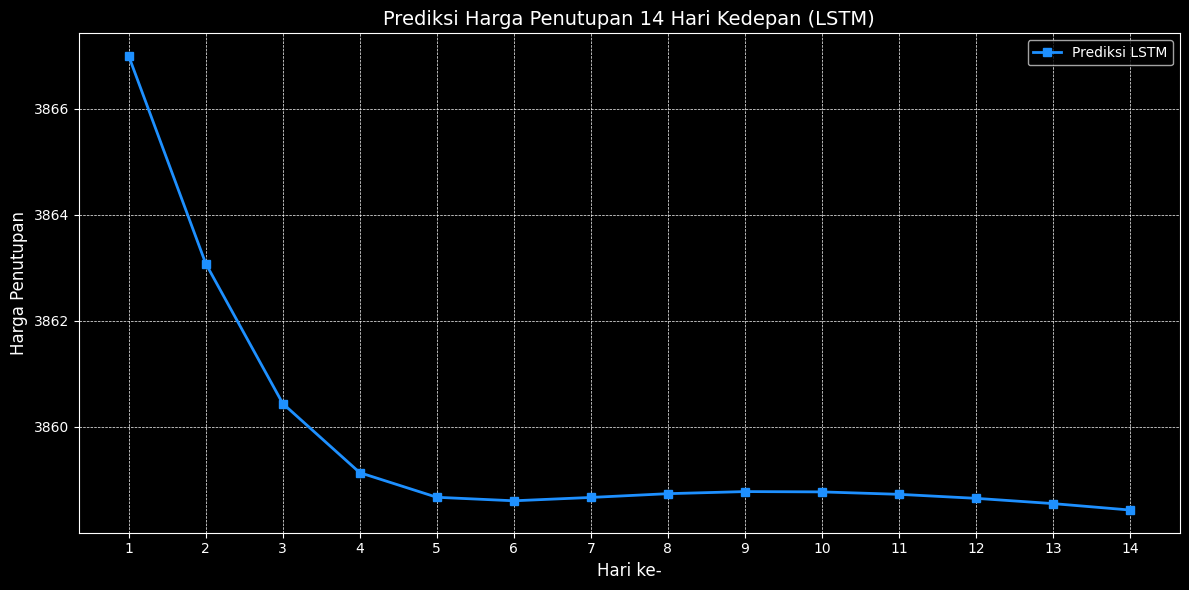

In [59]:
# Buat sumbu X: Hari ke-1 sampai ke-14
x_days = list(range(1, len(predicted_price_RNN) + 1))  # Misal 14 hari

# Plot Prediksi RNN
plt.figure(figsize=(12,6))
plt.plot(x_days, predicted_price_RNN.flatten(), label='Prediksi RNN', color='red', linestyle='-', linewidth=2, marker='o')
plt.title('Prediksi Harga Penutupan 14 Hari Kedepan (RNN)', fontsize=14)
plt.xlabel('Hari ke-', fontsize=12)
plt.ylabel('Harga Penutupan', fontsize=12)
plt.xticks(x_days)
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

# Plot Prediksi LSTM
plt.figure(figsize=(12,6))
plt.plot(x_days, predicted_price_LSTM.flatten(), label='Prediksi LSTM', color='#1E90ff', linestyle='-', linewidth=2, marker='s')
plt.title('Prediksi Harga Penutupan 14 Hari Kedepan (LSTM)', fontsize=14)
plt.xlabel('Hari ke-', fontsize=12)
plt.ylabel('Harga Penutupan', fontsize=12)
plt.xticks(x_days)
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

**Kesimpulan :**

BERDASARKAN DATA DARI YAHOO FINANCE :
*  Real Price pada 30/12/2024 adalah sebesar **`3.856.24`**
*  Real Price pada 2/1/2025 atau keesokan harinya adalah sebesar **`3.979.11`**
*  Prediction pada 2/1/2025 adalah sebesar ....
   - **`RNN    : 3.838.24`**
   - **`LSTM   : 3.866.99`**                       

==============================================================================================================
Metrik evaluasi pada testing data antara aKtual data dengan prediction :

**`RNN :`**
- **`MSE   = 9.340.06`**
- **`RMSE  = 96.64`**
- **`MAE   = 76.57`**

**`LSTM :`**
- **`MSE   = 5.535.33`**
- **`RMSE  = 74.40`**
- **`MAE   = 57.26`**